# Optimization analysis using genetic algorithm

In [92]:
import numpy as np
import geatpy as ea
import time

In [93]:
def object_function(population,CV):
    
    # define variables
    d = population[:,[0]] # pipe diameter
    N_t = population[:,[1]] # number of row
    n_t = population[:,[2]] # number of tube per row
    L = population[:,[3]] # length of tube bundle
    P_l = population[:,[4]] # row spacing
    P_t = population[:,[5]] # tube spacing
    mf_h = population[:,[6]] # hot water mass flow rate
    mf_c = population[:,[7]] # cold air mass flow rate
    
    T_hi = 60 + 273.15 # hot fluid inlet temperature
    T_ci = 40 + 273.15 # cold air inlet temperature
    T_ho = 46 + 273.15 # hot fluid outlet temperature
    cp_h = 4182 # hot fluid specific heat capacity
    cp_c = 1000 # cold air specific heat capacity
    
    rho_i = 1000 # hot fluid density
    rho_o = 1.2 # cold air density
    roughness = 0.001 # roughness of pipe
    dynamic_viscosity_i = 1 * (10**(-3)) # hot fluid dynamic viscosity
    dynamic_viscosity_o = 1.8 * (10**(-5)) # cold air dynamic viscosity
    K_L = 1 # minor friction loss coefficient
    eff_i = 0.8 # efficiency of inner flow
    eff_o = 1 # efficiency of outer flow
    eff_f = 0.7 # efficiency of fan
        
    A = np.pi * d * N_t * n_t * L # heat transfer area
    q = mf_h * cp_h * (T_hi - T_ho) # heat transfer rate
    T_co = q / (mf_c * cp_c) + T_ci # cold air outlet temperature
    
    dT1 = T_hi - T_co
    dT2 = T_ho - T_ci
    dT = dT1 - dT2
    logdT = np.log(dT1 / dT2)
    
    T_lm = dT / logdT # log mean temperature difference
    U = q / T_lm / A # overall heat transfer coefficient
    
    v_i = mf_h / (np.pi*0.25*(d**2)) / rho_i # hot fluid velocity
    volume_flow_i = mf_h / rho_i # hot fluid volume flow

    W = (N_t + 1) * P_l # width of tube bundle
    
    velocity_i = volume_flow_i / (np.pi*np.sqrt( 0.5*d )); # calculate the velocity in the pipe
    Re_i = rho_i * velocity_i * d / dynamic_viscosity_i ; # hot fluid Renolds Number
    friction = (1/(-1.8*(np.log10((roughness / d / 3.7)**1.11 + 6.9/Re_i))))**2 # friction coefficient
    
    dP_i = (friction * (N_t * n_t * L / d) + K_L) * 0.5 * rho_i * (v_i ** 2) # pressure loss in the pipe

    A_min = L * (W - N_t * d) # minimum air flow area
    G = mf_c / A_min # mass velocity
    v_o = G / rho_o # cold air velocity
    Re_o = rho_o * v_o * ((2 * A_min) / (L + W)) / dynamic_viscosity_o # cold air Renolds number
    dP_o = 37.86 * (Re_o**0.316) * ((P_l/d)**0.927) * ((P_l/P_t)**0.515) * n_t * (G**2)/(2*rho_o) # pressure loss across tube bundle

    dP_f = 0.5 * rho_o * (v_o ** 2) # pressure change across the fan

    dP_of = dP_o + dP_f # air side pressure change

    W_P = dP_i*mf_h/eff_i/rho_i + dP_o*mf_c/eff_o/rho_o + dP_f*mf_c/eff_f/rho_o # total power consumption

    return [W_P,CV]

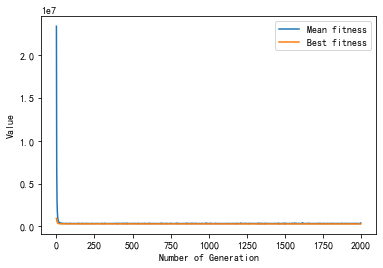

Objective function value： 932478.0977919275
Best individual：
x0= 0.028943248532289627
x1= 95.83195845023813
x2= 6.294575417715724
x3= 7.106202792401007
x4= 0.09500978473581213
x5= 0.09432485322896283
x6= 1.0283207446402685
x7= 50.45690623646972
time： 6.731001853942871 seconds


In [94]:
"""============================variable setting============================"""

# range of variables
x1 = [0.01, 0.05]
x2 = [50, 100]
x3 = [5, 10]
x4 = [5, 10]
x5 = [0.05, 0.1]
x6 = [0.05, 0.1]
x7 = [1, 5]
x8 = [50, 100]

# boundary setting
b1 = [1, 1]
b2 = [1, 1]
b3 = [1, 1]
b4 = [1, 1]
b5 = [1, 1]
b6 = [1, 1]
b7 = [1, 1]
b8 = [1, 1]

# generate matrix of variables range, boundary and types
ranges = np.vstack([x1, x2, x3, x4, x5, x6, x7, x8]).T
borders = np.vstack([b1, b2, b3, b4, b5, b6, b7, b8]).T
varTypes = np.array([0, 0, 0, 0, 0, 0, 0, 0])

"""==========================Encoding setting========================="""
Encoding = 'BG' # 'BG' indicates binary
codes = [0, 0, 0, 0, 0, 0, 0, 0] # all 8 variables use binary encoding
precisions =[4, 4, 4, 4, 4, 4, 4, 4] # precision
scales = [0, 0, 0, 0, 0, 0, 0, 0] # 0 indicate arithmetic scale，1 indicate logarithmic scale
FieldD = ea.crtfld(Encoding,varTypes,ranges,borders,precisions,codes,scales) # Encoding matrix

"""=========================Genetic algorithm setting========================"""
population_size = 1000; 
generations = 2000; 
maxormins = [1] # 1 indicates minimization of objective function，-1 indicates maximization
maxormins = np.array(maxormins) 
selectStyle = 'rws' # roulette wheel selection
recStyle  = 'xovdp' # two-point crossover
mutStyle  = 'mutbin' # Mutation for binary chromosomes
Lind      = int(np.sum(FieldD[0, :])) # chromosome length
pc        = 0.8 # crossover probability
pm        = 0.1 # mutation probability
obj_trace = np.zeros((generations, 2)) # storage for value of fitness function
var_trace = np.zeros((generations, Lind)) # storage for value of best fitness 

"""=========================Generation start========================"""
start_time = time.time() # start time
Chrom = ea.crtpc(Encoding, population_size, FieldD) # create matrix of chromosomes
variable = ea.bs2ri(Chrom, FieldD) # initial population decoding
CV = np.zeros((population_size, 1))
ObjV, CV = object_function(variable, CV) # calculate value of fitness function for initial population
FitnV = ea.ranking(ObjV, CV, maxormins) # ranking the values of fitness function
best_ind = np.argmax(FitnV) # calculate best fitness
# start generation
for gen in range(generations):
    SelCh = Chrom[ea.selecting(selectStyle,FitnV,population_size-1),:] # selection
    SelCh = ea.recombin(recStyle, SelCh, pc) # recombine
    SelCh = ea.mutate(mutStyle, Encoding, SelCh, pm) # mutation
    # repopulation
    Chrom = np.vstack([Chrom[best_ind, :], SelCh])
    population = ea.bs2ri(Chrom, FieldD) # binary to decimal
    ObjV, CV = object_function(population, CV) # value of fitness function
    FitnV = ea.ranking(ObjV, CV, maxormins) # ranking
    # recording
    best_ind = np.argmax(FitnV) # best individual
    obj_trace[gen,0]=np.sum(ObjV)/ObjV.shape[0] # mean value
    obj_trace[gen,1]=ObjV[best_ind] # best fitness
    var_trace[gen,:]=Chrom[best_ind,:] # best individual
# end genration
end_time = time.time()
ea.trcplot(obj_trace, [['Mean fitness', 'Best fitness']]) # plotting
"""============================Output============================"""
best_gen = np.argmax(obj_trace[:, [1]])
print('Objective function value：', obj_trace[best_gen, 1])
variable = ea.bs2ri(var_trace[[best_gen], :], FieldD) 
print('Best individual：')
for i in range(variable.shape[1]):
    print('x'+str(i)+'=',variable[0, i])
print('time：', end_time - start_time, 'seconds')